# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
import sys
sys.path.append("..")
from scem import ebm, stein, kernel, util, gen, net
from scem.datasets import *
import matplotlib.pyplot as plt
from collections import namedtuple

In [3]:
import torch 
import torch.nn as nn
from torch.nn.utils import spectral_norm
import numpy as np
import torch.distributions as td
torch.random.manual_seed(13)

In [4]:
dname = "fu"
p = load_data(dname, D=2, noise_std = 0.0, seed=0, itanh=False, whiten=False )

x = p.sample(1000)
x_eval = p.sample(100)

In [5]:
gpu = torch.cuda.is_available()
if gpu:
    device = torch.device('cuda:0')
    dtype = torch.float32

In [6]:
class EBM(nn.Module):
    
    '''
    EBM 
    '''
    
    def __init__(self, Dx, Dz, Dh):
        
        super().__init__()
        
        self.layer_1 = nn.Linear(Dz+Dx, Dh)
        self.layer_2 = nn.Linear(Dh, 1)
        self.elu = nn.ELU()
    
    def forward(self, X, Z):

        XZ = torch.cat([X, Z], axis=-1)
        #h  = self.elu(self.layer_1(XZ))
        h = torch.relu(self.layer_1(XZ))
        E  = self.layer_2(h)
        return E[:,0]
    

# dimensionality of model 
Dx = 2
Dz = 2
Dh = 100

In [7]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [8]:
X = torch.as_tensor(x, dtype=torch.float32)
if gpu:
    X = X.to(device)

In [9]:
class Net(nn.Module):
    def __init__(self, Dx):
        super(Net, self).__init__()
        self.scales = nn.Parameter(torch.ones([Dx]))
        
    def forward(self, X):
        return X * (self.scales**2)**0.5

In [1]:
# define kernel

med2 = util.pt_meddistance(X)**2
Df = 2
#f = net.TwoLayerFC(Dx, 100, 100, Df)

# f = Net(Dx)
# f.scales = nn.Parameter(torch.ones([Dx])/(med2/8)**0.5)

f = nn.Linear(Dx, Df, bias=False)
feat = kernel.FuncFeatureMap(f, (Dx,), (Df,))
# base_kernel = kernel.BKGauss(torch.tensor([1.0]))
base_kernel = kernel.BKIMQ()
kx = kernel.KSTFuncCompose(base_kernel, feat)
#kx = kernel.KGauss(torch.tensor(med2/8.))

NameError: name 'util' is not defined

In [ ]:
# q(z|x)
#cs = gen.CSFactorisedGaussian(Dx, Dz, Dh)
cs = cs = gen.Implicit(Dx, Dz, Dh)
# p(x,z)
lebm = ebm.LatentEBMAdapter(EBM(Dx, Dz, Dh), var_type_obs='continuous', var_type_latent='continuous')
if gpu:
    cs.to(device)
    lebm.to(device)

In [12]:
# approximate score
approx_score = stein.ApproximateScore(
        lebm.score_joint_obs, cs)
approx_score.n_sample = 100

In [13]:
def get_minibatch(batch_size, X, detach=True):
    perm = torch.randperm(X.shape[0]).detach()
    idx = perm[:batch_size]
    X_ = X[idx]
    if detach:
        X_ = X_.detach()
    return X_

In [14]:
def train_kernel(niter, gp=False):
    losses = []    
    
    for i in range(niter):
        X_ = get_minibatch(batch_size, X)
        ksdsq = stein.ksd_ustat(X_, approx_score, kx)
        loss = -ksdsq
        if gp:
            scale = stein.rkhs_reg_scale(X_, kx, sc=sc)
            loss = scale * loss
        #mean, var = stein.ksd_ustat(X_, approx_score, kx, return_variance=True)
        #loss = -mean  / (var + 1e-4)**0.5
        losses += [loss.item()]
       # print(loss.item())
        opt_kx.zero_grad()
        loss.backward(retain_graph=False)
        opt_kx.step()  

    print(scale.item())


    return losses

In [15]:
def train_q(niter, cs):
    k_ = kernel.KGauss(torch.tensor([med2/8]))
    #k_ = kx
    Z = cs.sample(1, X).squeeze(0)    

    losses = []   
    for i in range(niter):
        X_ = get_minibatch(batch_size, X)
        # X_ = X
        Z = cs.sample(1, X_)
        Z = Z.squeeze(0)
        zmed2 = util.pt_meddistance(Z)**2/8
        kz = kernel.KIMQ(b=-0.5, c=1, s2=zmed2)
        loss = stein.kcsd_ustat(
            X_, Z, lebm.score_joint_latent, k_, kz)
        losses += [loss.item()]
        opt_q.zero_grad()
        loss.backward(retain_graph=False)
        opt_q.step()   
    print('kcsd', loss.item())
        
    return losses

In [16]:
def train_with_ksd(niter, gp=False):
    losses = []
    for t in range(niter):
        X_ = get_minibatch(batch_size, X)
        train_q(iter_q, cs,)
        ksdsq = stein.ksd_ustat(X_, approx_score, kx) 
        loss = ksdsq
        if gp: 
            scale = stein.rkhs_reg_scale(X_, kx, sc=sc)
            loss *= (scale)**2
        losses += [loss.item()]
        opt_p.zero_grad()
        loss.backward(retain_graph=False)
        opt_p.step()
    return losses

In [17]:
OptimParam = namedtuple('OptimParam', 'lr wd')

oparam_q = OptimParam(1e-3, 0.)
oparam_p = OptimParam(1e-3, 0.)
oparam_kx = OptimParam(1e-3, 0.)

In [18]:
iter_all = 2000
batch_size = 100
iter_p = 1 # X.shape[0] // batch_size
iter_kx = 3

In [19]:
# optimizer settings
opt_q = torch.optim.Adam(cs.parameters(), lr=oparam_q.lr,
                         weight_decay=oparam_q.wd)
opt_p = torch.optim.Adam(lebm.parameters(), lr=oparam_p.lr,
                               weight_decay=oparam_p.wd)
opt_kx = torch.optim.Adam(kx.f.f.parameters(), lr=oparam_kx.lr,
                               weight_decay=oparam_kx.wd)
lr_sch_kx = torch.optim.lr_scheduler.ExponentialLR(opt_kx, gamma=0.999)
lr_sch_p = torch.optim.lr_scheduler.ExponentialLR(opt_p, gamma=0.999)

In [21]:
sc=0.1

In [33]:
# # decayRate = 1.0
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer_p, gamma=decayRate)
#train_q(50, cs)
losses = []
losses_kx = []
gp = True
for i_all in range(iter_all):   
    if i_all <= 10:
        iter_q = 10
        losses_kx += train_kernel(10, gp=gp)
        loss_list = train_with_ksd(niter=5, gp=gp)  
    else:
        iter_q = 1
        losses_kx += train_kernel(iter_kx, gp=gp)
        loss_list = train_with_ksd(niter=iter_p, gp=gp)  
    losses += loss_list

0.837493896484375
kcsd 0.004734436981379986
0.8374882340431213
kcsd 0.0015797640662640333
0.8374971747398376
kcsd 0.0020353992003947496
0.8374817967414856
kcsd 0.0043312981724739075
0.8375124931335449
kcsd 0.0005935884546488523
0.837587833404541
kcsd 0.008893076330423355
0.8376131057739258
kcsd 0.005554307252168655
0.8376029133796692
kcsd 0.00377332279458642
0.8375853300094604
kcsd 0.0016457559540867805
0.8375954627990723
kcsd -0.000640170939732343
0.8376455307006836
kcsd 0.007158019579946995
0.837681770324707
kcsd 0.0005908927414566278
0.8377233147621155
kcsd 0.009027899242937565
0.8377776145935059
kcsd 0.006986550986766815
0.8378119468688965
kcsd 0.004745367914438248
0.8378618955612183
kcsd 0.0035260641016066074
0.8379347324371338
kcsd 0.0011371003929525614
0.837961733341217
kcsd 0.006705834064632654
0.8380343317985535
kcsd 0.007064139470458031
0.8381479382514954
kcsd 0.0021571118850260973
0.8382571935653687
kcsd 0.0015942059690132737
0.8383548259735107
kcsd 0.001790917944163084
0.83

0.8459083437919617
kcsd 0.0037130459677428007
0.8458430767059326
kcsd -6.91392706357874e-05
0.8457577228546143
kcsd 0.003130813827738166
0.8456535339355469
kcsd 0.0034556009341031313
0.8455875515937805
kcsd 0.0025108661502599716
0.8455804586410522
kcsd -0.0003162792418152094
0.8456231355667114
kcsd 0.0009840686107054353
0.8456944227218628
kcsd 0.0012311484897509217
0.8458142280578613
kcsd 0.0023279148153960705
0.8459728360176086
kcsd 0.0021406570449471474
0.8460484147071838
kcsd 0.004724310711026192
0.8460842370986938
kcsd 0.003980201203376055
0.8460962772369385
kcsd 0.005715943872928619
0.8461006283760071
kcsd 0.010668129660189152
0.8460854291915894
kcsd 0.0022071870043873787
0.8461223244667053
kcsd 0.006762063596397638
0.8461615443229675
kcsd 0.0021382372360676527
0.8462285995483398
kcsd 0.0027945362962782383
0.8462735414505005
kcsd 0.0002126320032402873
0.8463003635406494
kcsd 0.005685124080628157
0.8462778925895691
kcsd 0.0011328586842864752
0.8462154269218445
kcsd 0.00273290299810

0.8522769808769226
kcsd 0.002361837076023221
0.8521765470504761
kcsd 0.0015445455210283399
0.8520258665084839
kcsd 0.002549772849306464
0.8518752455711365
kcsd 0.0036408533342182636
0.8517856001853943
kcsd 0.0034862710162997246
0.8517392873764038
kcsd 0.005430903751403093
0.8516948223114014
kcsd 0.0032029307913035154
0.8516470193862915
kcsd 0.006515942048281431
0.8515952229499817
kcsd 0.0073478976264595985
0.8515649437904358
kcsd 0.005422548390924931
0.8515724539756775
kcsd 0.004218040965497494
0.8515719771385193
kcsd 0.0008499438408762217
0.8516020178794861
kcsd 0.003755023004487157
0.8515727519989014
kcsd 0.0017549949698150158
0.8515819907188416
kcsd 0.003733224468305707
0.851597785949707
kcsd 0.004747855477035046
0.8516025543212891
kcsd 0.003642628900706768
0.8515395522117615
kcsd 0.001641124370507896
0.8514554500579834
kcsd 0.0021489460486918688
0.8513870239257812
kcsd 0.004184582736343145
0.8513367772102356
kcsd 0.0008102247375063598
0.8512969017028809
kcsd 0.0032814519945532084
0

0.8552618026733398
kcsd 0.004714449401944876
0.8553547859191895
kcsd 0.006763797253370285
0.8554227352142334
kcsd 0.0035561949480324984
0.85555499792099
kcsd 0.0028213346377015114
0.855790376663208
kcsd 0.005338495597243309
0.8559509515762329
kcsd 0.0013550914591178298
0.8560259342193604
kcsd -0.0008654369157738984
0.8560824990272522
kcsd 0.005151268560439348
0.8562037348747253
kcsd 0.0028377771377563477
0.8562367558479309
kcsd 0.0018040528520941734
0.856234073638916
kcsd 0.004770675674080849
0.8562065362930298
kcsd 0.0038570088800042868
0.8561319708824158
kcsd 0.004249355290085077
0.8560368418693542
kcsd -0.00042567396303638816
0.8558998107910156
kcsd 0.00029322615591809154
0.855725109577179
kcsd 0.003550451947376132
0.855599045753479
kcsd 0.0014340610941872
0.8555161356925964
kcsd 0.003437761915847659
0.8553781509399414
kcsd 0.0013986730482429266
0.8551772236824036
kcsd 0.006441100034862757
0.8549602031707764
kcsd 0.0014435184421017766
0.8547466993331909
kcsd 0.0009803680004552007
0.

0.8518127799034119
kcsd 0.001894841087050736
0.8517751693725586
kcsd 0.007785129826515913
0.8517034649848938
kcsd 0.00035470366128720343
0.8517138361930847
kcsd 0.00040256077772937715
0.8518047332763672
kcsd 0.0025780033320188522
0.8518993854522705
kcsd -0.0004792662221007049
0.8519745469093323
kcsd 0.0003500489401631057
0.8521039485931396
kcsd 0.0006261420785449445
0.8522403836250305
kcsd 0.001725015346892178
0.8523450493812561
kcsd 0.0036458533722907305
0.8523948788642883
kcsd 0.0031418772414326668
0.8523398637771606
kcsd 0.0074825771152973175
0.8522593379020691
kcsd 0.0033215670846402645
0.8521575331687927
kcsd 0.001646340126171708
0.8522477149963379
kcsd 0.002337415236979723
0.8524304628372192
kcsd 0.00246523623354733
0.8526046872138977
kcsd 0.0014341705245897174
0.8527516722679138
kcsd 0.0001463595253881067
0.8528022170066833
kcsd 0.000302453845506534
0.8527997136116028
kcsd 0.004626390989869833
0.8527974486351013
kcsd 0.004278929904103279
0.8528160452842712
kcsd 0.001861131400801

0.8537231087684631
kcsd 0.005225225817412138
0.8536246418952942
kcsd 0.0038665246684104204
0.8535031676292419
kcsd 0.0010931288124993443
0.8534234762191772
kcsd 0.002204694552347064
0.8533849716186523
kcsd 0.0012107972288504243
0.8533980846405029
kcsd -0.0008569675264880061
0.8534334301948547
kcsd 0.004895747173577547
0.8534061908721924
kcsd 0.00446240184828639
0.8533360362052917
kcsd 0.00337608577683568
0.8532727360725403
kcsd 0.0007918663905002177
0.8532023429870605
kcsd 0.00010421290789963678
0.8531489372253418
kcsd 0.0036419969983398914
0.853167712688446
kcsd 0.0020649179350584745
0.8532472252845764
kcsd 0.005510677583515644
0.8533510565757751
kcsd 0.004726650193333626
0.8534349799156189
kcsd 0.0010036060120910406
0.8535069823265076
kcsd 0.002741101197898388
0.8536329865455627
kcsd 0.0004726525512523949
0.8537799119949341
kcsd 0.001825604704208672
0.8539454936981201
kcsd 0.0024970530066639185
0.8539989590644836
kcsd 0.004033193923532963
0.8540359139442444
kcsd 0.005221989005804062


0.8564469814300537
kcsd 0.0015519513981416821
0.8564300537109375
kcsd 0.001327181700617075
0.8564300537109375
kcsd 0.0064432392828166485
0.8564357161521912
kcsd 0.00152587890625
0.8563041687011719
kcsd 0.0021198326721787453
0.8562395572662354
kcsd 0.0005979580455459654
0.8562005162239075
kcsd 0.0027015130035579205
0.8560569882392883
kcsd 0.0018830872140824795
0.8559325337409973
kcsd 0.001937046297825873
0.855965793132782
kcsd 0.0036648991517722607
0.8559728264808655
kcsd 0.006011323072016239
0.8560484647750854
kcsd 0.0024345368146896362
0.8561161756515503
kcsd 0.002853990066796541
0.856052041053772
kcsd 0.0030419104732573032
0.8559659719467163
kcsd 0.00391768803820014
0.8559169769287109
kcsd 0.005796420853585005
0.8558487296104431
kcsd -0.0005355927278287709
0.8556888699531555
kcsd 0.0008329649572260678
0.8555812239646912
kcsd 0.0018976971041411161
0.8555099368095398
kcsd 0.0023606549948453903
0.855508029460907
kcsd 0.003891610773280263
0.8554758429527283
kcsd 0.0030181684996932745
0.8

0.8584547638893127
kcsd 0.00034542815410532057
0.8584879040718079
kcsd 0.0006167109240777791
0.8584351539611816
kcsd -0.0008370986906811595
0.858329176902771
kcsd 0.004299008287489414
0.8581621646881104
kcsd 0.003315787296742201
0.8579925894737244
kcsd 0.0006892348756082356
0.8578317761421204
kcsd 0.0006579096661880612
0.8577123880386353
kcsd 0.0023235513363033533
0.8576985001564026
kcsd 0.0028756975661963224
0.8576688766479492
kcsd 0.0024744300171732903
0.8577719926834106
kcsd 0.002371450187638402
0.857859194278717
kcsd 0.0075832451693713665
0.8577854633331299
kcsd -3.942624516639626e-06
0.8576653599739075
kcsd 0.00019687229359988123
0.8576356172561646
kcsd 0.0019358671270310879
0.8575841188430786
kcsd 0.0075184074230492115
0.8573963642120361
kcsd 0.005513223819434643
0.857240617275238
kcsd 0.0002690741093829274
0.8572188019752502
kcsd 0.003699695225805044
0.8571848273277283
kcsd 0.0011470525059849024
0.8571648597717285
kcsd 0.0018650448182597756
0.8571728467941284
kcsd 0.002412833739

0.8605565428733826
kcsd 0.0020094099454581738
0.8606802225112915
kcsd 0.0043755825608968735
0.8608902096748352
kcsd 0.003841256722807884
0.8611776828765869
kcsd 0.0019543797243386507
0.861438512802124
kcsd 0.005542927887290716
0.8616335988044739
kcsd 0.005095026921480894
0.8619518280029297
kcsd 0.0028161760419607162
0.8623532056808472
kcsd 0.000229637065785937
0.86265629529953
kcsd 0.0006343571585603058
0.8628636002540588
kcsd 0.004193369764834642
0.8628577589988708
kcsd 0.0023791673593223095
0.8628472685813904
kcsd 0.0020206028129905462
0.8628333210945129
kcsd 0.005607051774859428
0.8626927733421326
kcsd 0.007348136510699987
0.8625971674919128
kcsd -0.0006802059942856431
0.8625837564468384
kcsd 0.005064846947789192
0.8626834750175476
kcsd 0.00021290172298904508
0.8627874255180359
kcsd 0.0027459377888590097
0.8628153800964355
kcsd 0.002413169713690877
0.8628488779067993
kcsd 0.002523429226130247
0.8629074692726135
kcsd 0.006226028315722942
0.863002598285675
kcsd -0.0007873750873841345


0.8691965341567993
kcsd 0.0007864009821787477
0.8693538904190063
kcsd -2.9947300390631426e-06
0.8695473670959473
kcsd 0.0023329779505729675
0.8697675466537476
kcsd 0.0017603433225303888
0.8700587749481201
kcsd 0.001951082842424512
0.8704375624656677
kcsd 0.0001631118357181549
0.8707194924354553
kcsd 0.0012149448739364743
0.8709321022033691
kcsd 0.00012964576308149844
0.8711614608764648
kcsd 0.0012104273773729801
0.8712713718414307
kcsd 0.0014693443663418293
0.8711957335472107
kcsd 0.004344910848885775
0.8711771368980408
kcsd 0.001487964647822082
0.8712150454521179
kcsd 0.004090391099452972
0.8711429238319397
kcsd 0.0008522387943230569
0.8710867166519165
kcsd 0.001605421886779368
0.8710917830467224
kcsd 0.00216251565143466
0.8711984753608704
kcsd 0.003782111220061779
0.8713692426681519
kcsd 0.0019149348372593522
0.8715366125106812
kcsd 0.0006835536914877594
0.8717130422592163
kcsd 0.0026584016159176826
0.871864378452301
kcsd 0.003975161351263523
0.8719428181648254
kcsd 0.004586838185787

0.8775560259819031
kcsd 0.0011238869046792388
0.877609372138977
kcsd 0.00016061186033766717
0.8778582215309143
kcsd 0.003790808841586113
0.8779769539833069
kcsd 0.0030063483864068985
0.8780051469802856
kcsd -0.0014988138573244214
0.8781585693359375
kcsd -0.001184720080345869
0.8783359527587891
kcsd 0.0032707168720662594
0.8784379363059998
kcsd 0.003401265712454915
0.8786172866821289
kcsd 0.0020048029255121946
0.8787186741828918
kcsd 0.003815934993326664
0.878602147102356
kcsd 0.0016201705439016223
0.8784993290901184
kcsd 0.0037743353750556707
0.8785821795463562
kcsd 0.0006884565227665007
0.878567636013031
kcsd 0.0015078334836289287
0.8783198595046997
kcsd 0.00167745107319206
0.8778574466705322
kcsd -0.0004974473267793655
0.8774290680885315
kcsd 0.004568424541503191
0.8770012259483337
kcsd 0.003824681742116809
0.8768066167831421
kcsd 0.0012561759212985635
0.876505970954895
kcsd 0.0033547990024089813
0.8763630986213684
kcsd 0.0016229602042585611
0.8762395977973938
kcsd 0.0033404864370822

0.8728260397911072
kcsd 0.003585351398214698
0.872660756111145
kcsd 0.00869316142052412
0.8724257946014404
kcsd 0.0034756732638925314
0.8722798228263855
kcsd 0.0002012218174058944


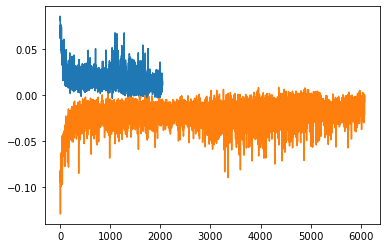

In [23]:
plt.plot(losses)
plt.plot(losses_kx)

In [25]:
# form a grid for numerical normalisation
from itertools import product
ngrid = 50
grid = torch.linspace(-10, 10, ngrid)
xz_eval = torch.tensor(list(product(*[grid]*4)))
if gpu:
    xz_eval = xz_eval.to(device)
x_eval = xz_eval[:,:2]
z_eval = xz_eval[:,2:]

In [26]:
# true log density
E_true = p.logpdf_multiple(torch.tensor(list(product(*[grid]*2))))
E_true -= E_true.max()

In [27]:
# EBM log density
E_eval = lebm(x_eval, z_eval).reshape(ngrid,ngrid,ngrid,ngrid).exp().cpu().detach()
E_eval /= E_eval.sum()
E_eval = E_eval.sum(-1).sum(-1)
E_eval.log_()
E_eval -= E_eval.max()
# E_eval = E_eval.sum(-1).sum(-1)

In [28]:
def normalise(E):
    if isinstance(E, np.ndarray):
        E = np.exp(E)
    else:
        E = E.exp()
    E /= E.sum()
    return E

(-10.0, 10.0)

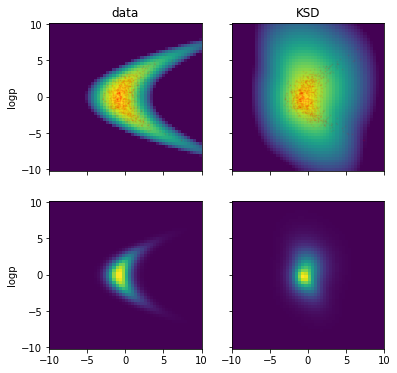

In [29]:
fig, axes = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)


ax = axes[0,0]
ax.pcolor(grid, grid,E_true.reshape(ngrid,ngrid), shading='auto', vmin=-10, vmax=0)
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)


ax = axes[1,0]
ax.pcolor(grid, grid,normalise(E_true).reshape(ngrid,ngrid), shading='auto')




ax = axes[0,1]
ax.pcolor(grid, grid,E_eval,shading='auto', vmin=-10, vmax=0, )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.05)


ax = axes[1,1]
ax.pcolor(grid, grid,normalise(E_eval),shading='auto' )
ax.scatter(x[:,1], x[:,0], c="r", s=1, alpha=0.0)



axes[0,0].set_ylabel("logp")
axes[1,0].set_ylabel("logp")

axes[0,0].set_title("data")
axes[0,1].set_title("KSD")

axes[0,0].set_xlim(-10,10)

In [30]:
feat.component_grad(X, 1)

tensor([[-0.0233, -0.3147],
        [-0.0233, -0.3147],
        [-0.0233, -0.3147],
        ...,
        [-0.0233, -0.3147],
        [-0.0233, -0.3147],
        [-0.0233, -0.3147]], grad_fn=<MmBackward>)

In [31]:
feat(torch.ones([1, X.shape[1]]))

tensor([[-1.3112, -0.3380, -1.1805,  0.2520]], grad_fn=<MmBackward>)

In [32]:
for param in f.parameters():
    print(param)

Parameter containing:
tensor([[-0.8034, -0.5077],
        [-0.0233, -0.3147],
        [-0.7215, -0.4590],
        [-0.2998,  0.5518]], requires_grad=True)
